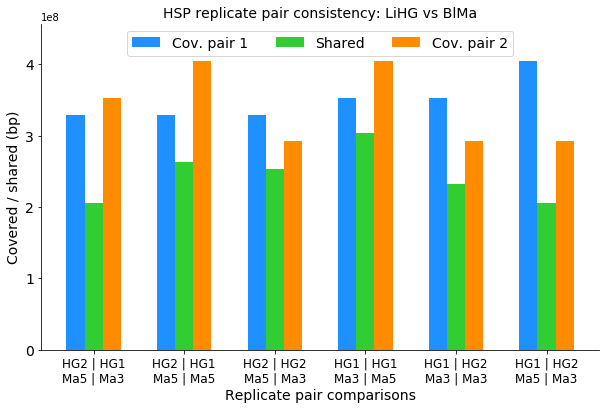

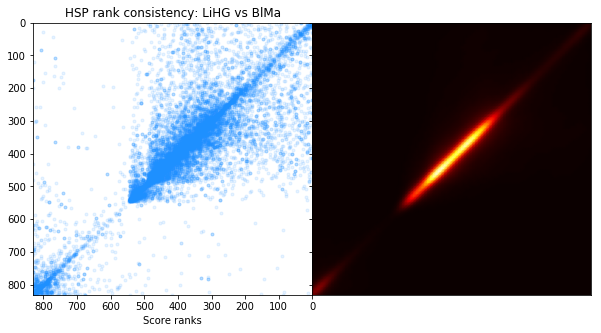

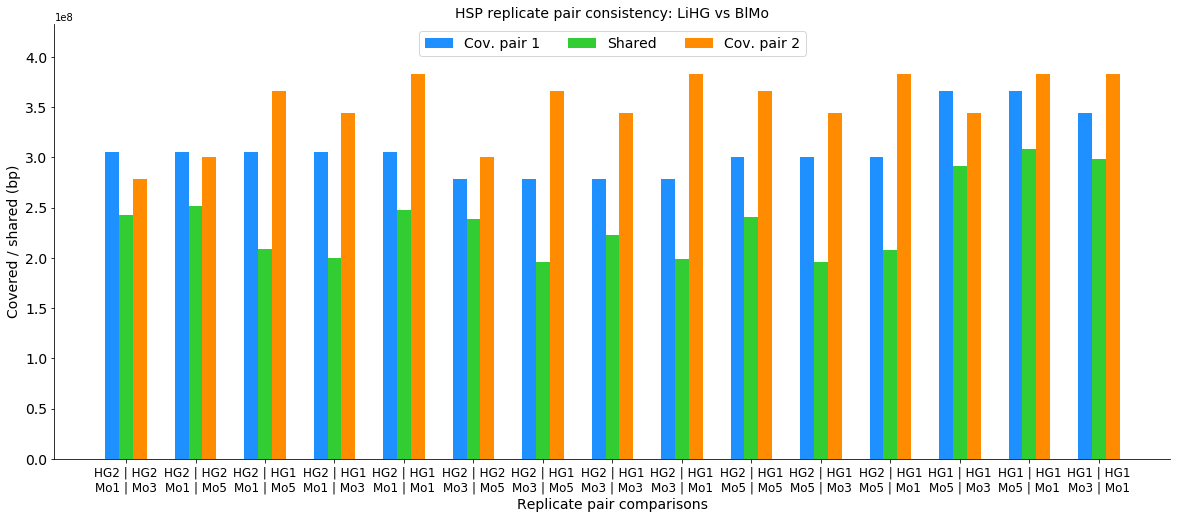

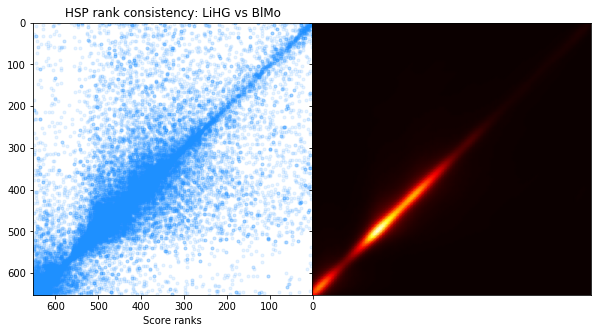

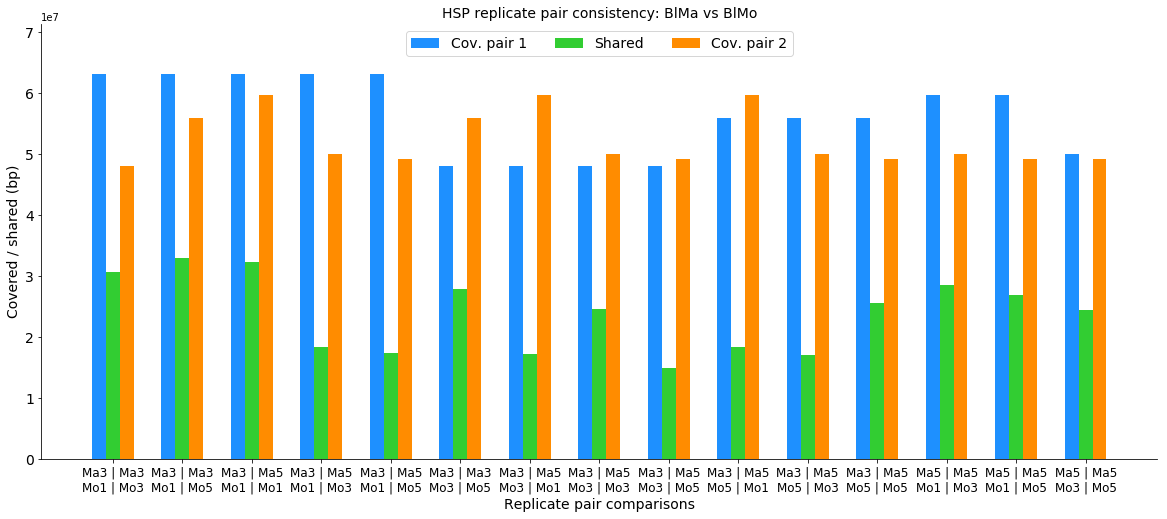

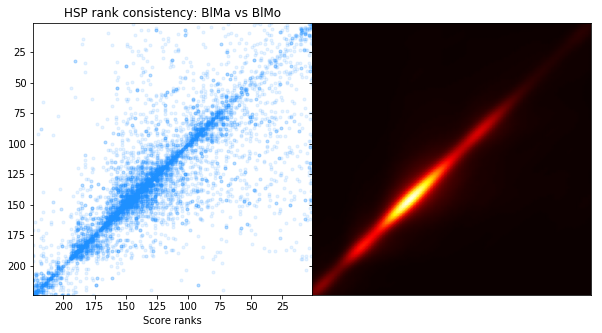

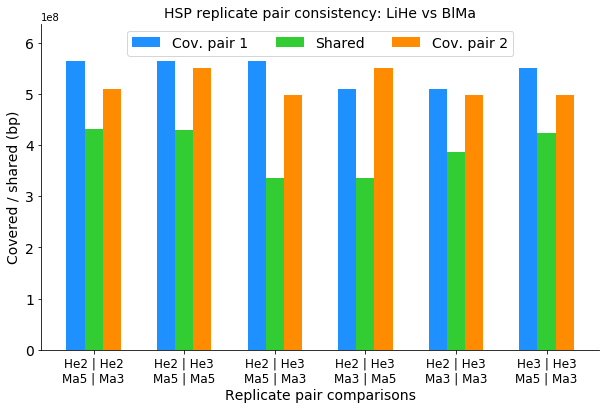

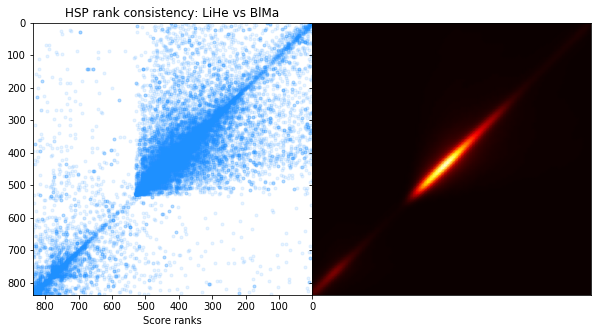

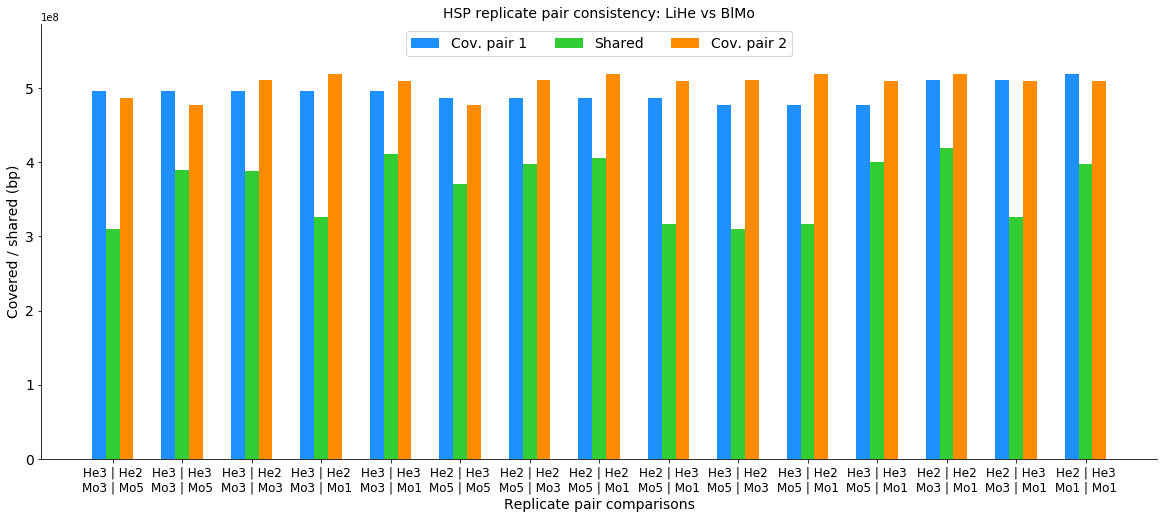

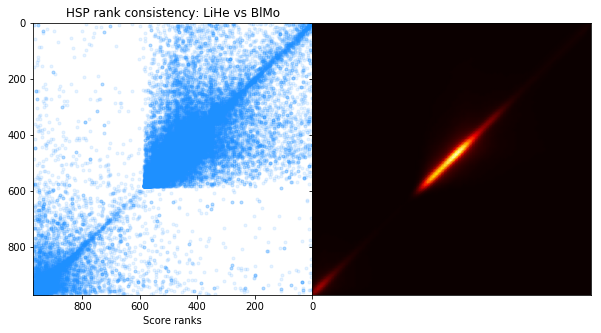

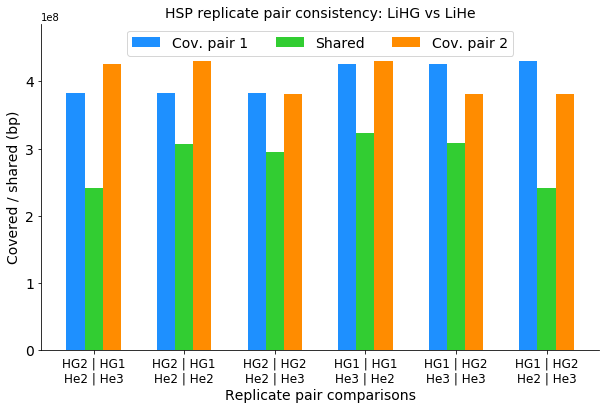

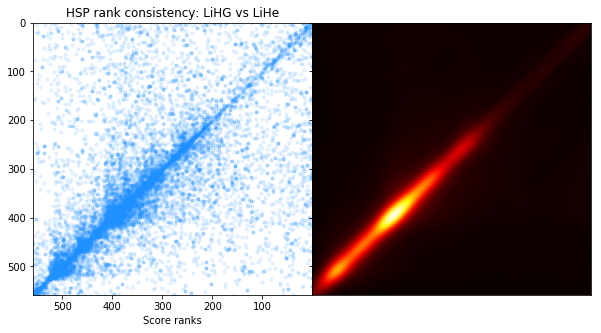

In [8]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import scipy.special as scisp
import scipy.stats.mstats as mstats
import pandas as pd

np.seterr(all='raise')

run_comparison = True

cache_dir = '/home/pebert/.jupyter/cache'
root_folder = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff/solidstate/deep'

ovl_files = []
for fname in os.listdir(os.path.join(root_folder, 'hsp_bed')):
    if fname.endswith('.ovl.bed'):
        ovl_files.append(os.path.join(root_folder, 'hsp_bed', fname))

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
show_figures = True
save_figures = True


def collect_overlap_stats(ovl_files, cache_file):
    if not os.path.isfile(cache_file):
        header = ['chrom', 'start', 'end', 'name', 'score',
                  'segpv', 'summpv', 'sample1', 'sample2', 'rank', 'pctrank']
        col_names = []
        for suffix in ['_a', '_b']:
            for h in header:
                col_names.append(h + suffix)
        col_names.append('overlap')
        ovl_stats = col.Counter()
        cov_stats = col.Counter()
        rnk_stats = col.defaultdict(list)
        for of in ovl_files:
            table = pd.read_csv(of, sep='\t', header=None,
                                names=col_names, index_col=False)
            table['pair1'] = table['sample1_a'] + '_vs_' + table['sample2_a']
            table['pair2'] = table['sample1_b'] + '_vs_' + table['sample2_b']
            table['quad'] = table['pair1'] + '_cmp_' + table['pair2']
            sub_same = table.loc[table['pair1'] == table['pair2'], ['pair1', 'start_a', 'end_a']]
            for pair in sub_same['pair1'].unique():
                pair_cov = sub_same.loc[sub_same['pair1'] == pair, ['start_a', 'end_a']]
                pair_cov = (pair_cov['end_a'] - pair_cov['start_a']).sum()
                s1, s2 = pair.split('_vs_')
                cov_stats[(s1, s2)] += int(pair_cov)
            sub_diff = table.loc[table['pair1'] != table['pair2'], ['quad', 'overlap', 'rank_a', 'rank_b']]
            for quad in sub_diff['quad'].unique():
                sub_quad = sub_diff.loc[sub_diff['quad'] == quad, :]
                p1, p2 = quad.split('_cmp_')
                s1, s2 = p1.split('_vs_')
                s3, s4 = p2.split('_vs_')
                rnk_stats[(s1, s2, s3, s4)].extend([(a, b) for a, b in zip(sub_quad['rank_a'], sub_quad['rank_b'])])
                ovl_stats[(s1, s2, s3, s4)] += int(sub_quad['overlap'].sum())
        data = {'overlap': ovl_stats, 'coverage': cov_stats, 'ranks': rnk_stats, 'timestamp': ti.ctime()}
        with open(cache_file, 'wb') as cache:
            pck.dump(data, cache)
    else:
        with open(cache_file, 'rb') as cache:
            data = pck.load(cache)
            
    return data

def identify_pair_replicates(pairs):
    pair_reps = col.defaultdict(list)
    for p1, p2 in pairs:
        c1 = p1.split('_')[1]
        c2 = p2.split('_')[1]
        pair_reps[(c1, c2)].append((p1, p2))
    return pair_reps

def plot_replicate_consistency(cell_pair, rep_pairs, data):
    cov = data['coverage']
    ovl = data['overlap']
    ht_p1 = []
    ht_sh = []
    ht_p2 = []
    x_labels = []
    bar_width = 0.5
    c1 = cell_pair[0][2:]
    c2 = cell_pair[1][2:]
    for p1, p2 in itt.combinations(rep_pairs, 2):
        d1 = c1 + p1[0].split('_')[0][3:]
        d2 = c2 + p1[1].split('_')[0][3:]
        d3 = c1 + p2[0].split('_')[0][3:]
        d4 = c2 + p2[1].split('_')[0][3:]
        x_labels.append('{} | {}\n{} | {}'.format(d1, d3, d2, d4))
        
        p_cov = cov[p1]
        ht_p1.append(p_cov)
        shared = ovl[tuple([*p1, *p2])]
        ht_sh.append(shared)
        p_cov = cov[p2]
        ht_p2.append(p_cov)
        
    ht_p1 = np.array(ht_p1, dtype=np.int32)
    ht_p2 = np.array(ht_p2, dtype=np.int32)
    ht_sh = np.array(ht_sh, dtype=np.int32)

    num_bars = ht_p1.size
    if num_bars < 7:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    max_height = max(ht_p1.max(), ht_p2.max())
    
    legend_space = np.round(max_height * 0.13, 0)
    
    ax.set_ylim(0, max_height + legend_space)
        
    g1_xlocs = np.arange(0, ht_p1.size * 3, step=2.5)[:num_bars]    
    ax.bar(g1_xlocs, ht_p1, bar_width, color='dodgerblue', label='Cov. pair 1')
    
    sh_xlocs = g1_xlocs + bar_width
    ax.bar(sh_xlocs, ht_sh, bar_width, color='limegreen', label='Shared')
    
    x_ticks = sh_xlocs
    
    g2_xlocs = sh_xlocs + bar_width
    ax.bar(g2_xlocs, ht_p2, bar_width, color='darkorange', label='Cov. pair 2')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=12)
    
    ax.set_xlabel('Replicate pair comparisons', fontsize=14)
    ax.set_ylabel('Covered / shared (bp)', fontsize=14)
    
    ax.set_title('HSP replicate pair consistency: {} vs {}'.format(cell_pair[0], cell_pair[1]),
                 fontsize=14)
    for item in ax.get_yticklabels():
        item.set_fontsize(14)
    ax.legend(loc='upper center', fontsize=14, ncol=3)
    return fig, []


def plot_rank_consistency(cell_pair, rep_pairs, data):
    ranks = data['ranks']
    x_vals, y_vals = [], []
    for p1, p2 in itt.combinations(rep_pairs, 2):
        rnk = ranks[tuple([*p1, *p2])]
        [(x_vals.append(t[0]), y_vals.append(t[1])) for t in rnk]

    fig, (scat, dens) = plt.subplots(1, 2, sharex=False,
                                     sharey=True, figsize=(10, 5))
    fig.subplots_adjust(wspace=0)
    scat.set_title('HSP rank consistency: {} vs {}'.format(*cell_pair))
    scat.set_xlabel('Score ranks')
    
    x_vals = np.array(x_vals, dtype=np.int32)
    y_vals = np.array(y_vals, dtype=np.int32)
    
    scat.set_xlim(x_vals.max(), x_vals.min())
    scat.set_ylim(y_vals.max(), y_vals.min())

    dens.set_xlim(x_vals.max(), x_vals.min())
    dens.set_xticks([])

    # downsample for scatter        
#     for pct, a in zip([1, 0.6, 0.4, 0.05],
#                       [0.05, 0.1, 0.2, 0.4]):
    for pct, a in zip([0.1, 0.01],
                      [0.1, 0.3]):
        smp_size = int(np.round(x_vals.size * pct, 0))
        sample = rng.choice(np.arange(x_vals.size),
                            size=smp_size, replace=False)
        sub_x = x_vals[sample]
        sub_y = y_vals[sample]
        scat.scatter(sub_x, sub_y, color='dodgerblue', alpha=a, marker='.')

    # plot density
    dataset = np.vstack((x_vals, y_vals))
    nbins = 100
    gauss = stats.gaussian_kde(dataset, bw_method='silverman')
    xi, yi = np.mgrid[x_vals.max():x_vals.min():nbins*1j, y_vals.max():y_vals.min():nbins*1j]
    est_points = np.vstack([xi.flatten(), yi.flatten()])
    est_dens = gauss(est_points)
    dens.pcolormesh(xi, yi, est_dens.reshape(xi.shape), shading='gouraud', cmap='hot')
    return fig, []
    

if run_comparison:
    iv_stats = collect_overlap_stats(ovl_files, os.path.join(cache_dir, 'hsp_isect_stats.pck'))
    pair_reps = identify_pair_replicates(list(iv_stats['coverage'].keys()))
    for cell_pair, sample_pairs in pair_reps.items():
        fig, exart = plot_replicate_consistency(cell_pair, sample_pairs, iv_stats)
        if save_figures:
            outpath = os.path.join(fig_supp, 'fig_X_supp_bar_rnk-cons_{}.svg'.format('emission'))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
        fig, exart = plot_rank_consistency(cell_pair, sample_pairs, iv_stats)
        if save_figures:
            outpath = os.path.join(fig_supp, 'fig_X_supp_dens_rnk-cons_{}.svg'.format('emission'))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
